# Выбор локации для скважины

Нефтедобывающей компании нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой ***Bootstrap***.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах: 

- /datasets/geo_data_0.csv;
- /datasets/geo_data_1.csv;
- /datasets/geo_data_2.csv;

Признаки:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [1]:
# Константы
RANDOM_STATE = 12345
BUDGET = 1e10 # бюджет
N_WELL = 200    # количество скважин
UNIT_PRICE = 450000  # цена единицы объема нефти

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [3]:
# загрузка данных
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('geo_data_0.csv')
    data_1 = pd.read_csv('geo_data_1.csv')
    data_2 = pd.read_csv('geo_data_2.csv')

In [4]:
data_all = [data_0, data_1, data_2]

Посмотрим на данные

In [5]:
for i, data in enumerate(data_all):
    print(f'Регион {i}')
    display(data.head(5))
    display(data.info())

Регион 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Регион 1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Регион 2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Названия столбцов и типы данных корректны, пропуски отсутствуют.  
Проверим уникальность ID скважин.

In [6]:
def dup_check():
    """
    Функция считает количество дубликатов ID в данных по регионам
    """
    for i, data in enumerate(data_all):
        print(f'В регионе {i} {data.duplicated(subset=["id"]).sum()} дубликатов(а)')

In [7]:
dup_check()

В регионе 0 10 дубликатов(а)
В регионе 1 4 дубликатов(а)
В регионе 2 4 дубликатов(а)


Взглянем на дубликаты

In [8]:
for i, data in enumerate(data_all):
    print(f'Дубликаты ID в регионе {i}')
    display(data[data['id'].duplicated(keep=False)].sort_values(by = 'id'))
    print()

Дубликаты ID в регионе 0


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502



Дубликаты ID в регионе 1


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305



Дубликаты ID в регионе 2


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Имеются дубликаты ID, при этом признаки в скважинах с одним и тем же ID различаются. Это странно. Однако таких скважин немного, поэтому их можно удалить.

In [9]:
for data in data_all:
    data.drop_duplicates(subset=['id'], keep=False, inplace = True)
    
dup_check()

В регионе 0 0 дубликатов(а)
В регионе 1 0 дубликатов(а)
В регионе 2 0 дубликатов(а)


Посмотрим на гистограммы признаков

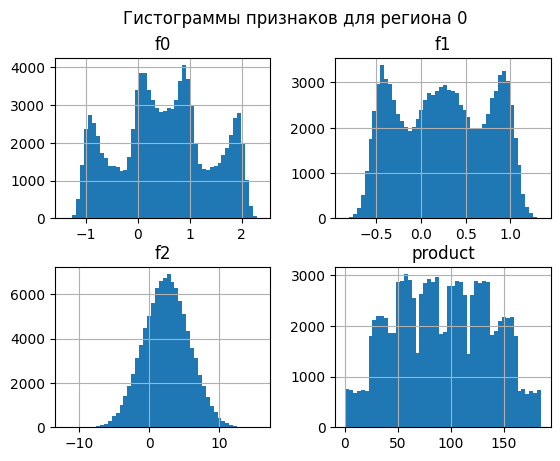

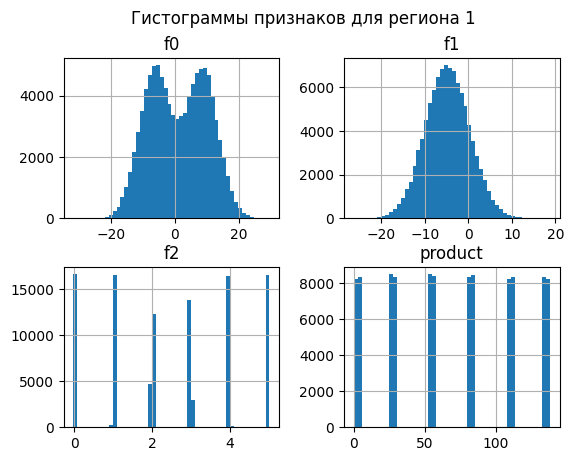

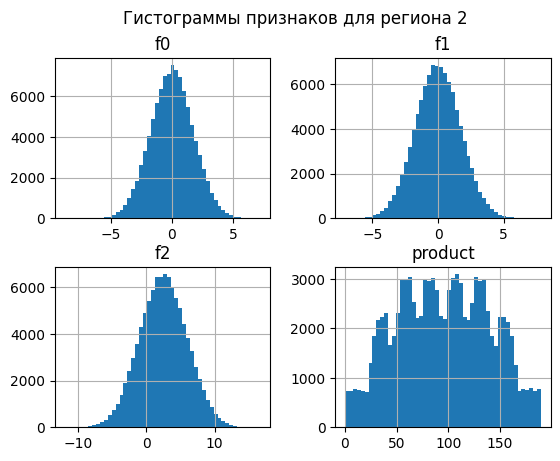

In [10]:
for i, data in enumerate(data_all):
    data.hist(bins = 50)
    plt.suptitle(f'Гистограммы признаков для региона {i}');

Выбросов не видно.

Посмотрим матрицы рассеяния признаков

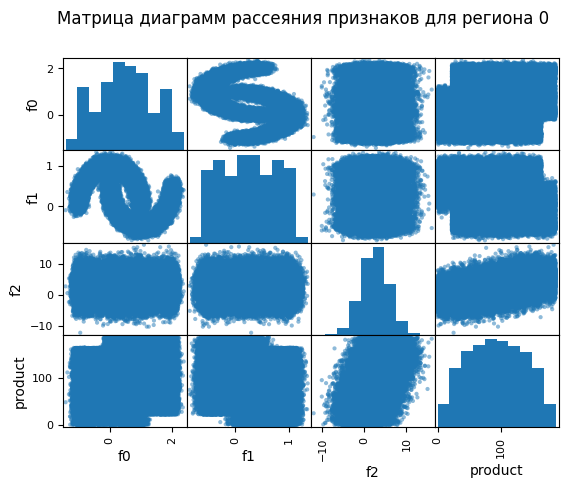

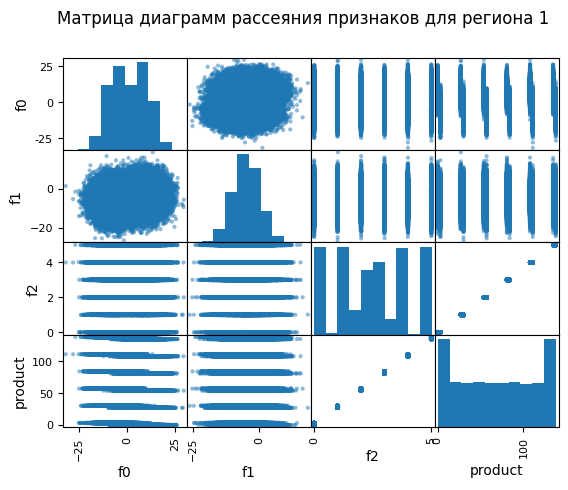

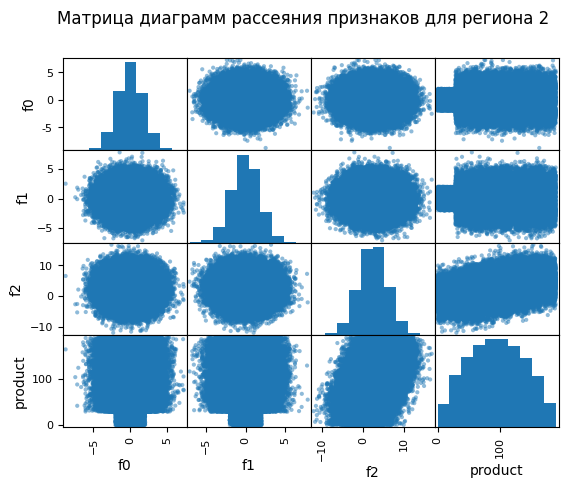

In [11]:
for i, data in enumerate(data_all):
    pd.plotting.scatter_matrix(data)
    plt.suptitle(f'Матрица диаграмм рассеяния признаков для региона {i}');

Сильных линейных зависимостей между признаками нет. В регтоне "1" наблюдается сильная линейная зависимость между признаком "f2" и целевым признаком "product", что, вероятно, повысит вес данного признака в модели линейной регрессии. Необхоодимо провести стандартизацию признаков. 

Разделим данные на признаки и целевой признак.

In [12]:
def separator(df):
    """
    Функция выделяет из данных признаки и целевой пртзнак
    """
    features = df.drop(columns = ['id', 'product'])
    target = df[['product']]
    return features, target

In [13]:
# разделение данных на признаки и целевой признак

features_0, target_0 = separator(data_0)
features_1, target_1 = separator(data_1)
features_2, target_2 = separator(data_2)

Разделим признаки на тренировочные и валидационные

In [14]:
# разделение признаков на тренировочные и валидационные
features_0_train, features_0_valid, target_0_train, target_0_valid = \
    train_test_split(features_0, target_0, test_size=0.25, random_state=RANDOM_STATE)

features_1_train, features_1_valid, target_1_train, target_1_valid = \
    train_test_split(features_1, target_1, test_size=0.25, random_state=RANDOM_STATE)

features_2_train, features_2_valid, target_2_train, target_2_valid = \
    train_test_split(features_2, target_2, test_size=0.25, random_state=RANDOM_STATE)

Стандартизируем признаки.

In [15]:
# инициализация модели стандартизации
scaler = StandardScaler()

# обучение модели и стандартизация признаков
features_0_train = scaler.fit_transform(features_0_train)
features_0_valid = scaler.transform(features_0_valid)

features_1_train = scaler.fit_transform(features_1_train)
features_1_valid = scaler.transform(features_1_valid)

features_2_train = scaler.fit_transform(features_2_train)
features_2_valid = scaler.transform(features_2_valid)

## Обучение и проверка модели

Создадим и обучим модель линейной регрессии для предсказания целевого признака по остальным.

In [16]:
def predict_reg(features_train, target_train, features_valid, target_valid):
    """
    Функция возвращает обученную модель и печатает параметры
    """
    # инициализация модели линейной регрессии
    model = LinearRegression()

    # обучение модели линейной регрессии
    model.fit(features_train, target_train)

    # получение предсказаний и расчет показателей
    predictions= model.predict(features_valid)
    print('Средний запас предсказанного сырья:', predictions.mean())
    print('RMSE =', mean_squared_error(target_valid, predictions)**0.5)
    return model

Для региона "0"

In [17]:
model_0 = predict_reg(features_0_train, target_0_train, features_0_valid, target_0_valid)

Средний запас предсказанного сырья: 92.42384109947359
RMSE = 37.716904960382735


Для региона "1"

In [18]:
model_1 = predict_reg(features_1_train, target_1_train, features_1_valid, target_1_valid)

Средний запас предсказанного сырья: 68.98311857983121
RMSE = 0.8914901390348542


Для региона "2"

In [19]:
model_2 = predict_reg(features_2_train, target_2_train, features_2_valid, target_2_valid)

Средний запас предсказанного сырья: 95.11622302076478
RMSE = 39.975543264382345


**Выводы**

На первый взгляд объемы нефти в скважинах регионов "0" и "2" превышают данный показатель в регионе "1". Однако модели, разработанные для этих регионов, имеют значительно худшую точность предсказаний, что может повысить риски убыточной разработки из-за неверного прогноза.

## Подготовка к расчёту прибыли

Рассчитаем средний объем сырья в скважинах, необходимый  для безубыточной разработки.

In [20]:
payback_volume = BUDGET / N_WELL / UNIT_PRICE
print('Минимальный объем нефти в скважине для её окупаемости:', payback_volume)

Минимальный объем нефти в скважине для её окупаемости: 111.11111111111111


**Выводы**

Видно, что этот объем существенно выше, чем средний объем нефти в скважинах любого из регионов. Поэтому перед разработкой необходимо выбрать места, где наибольшая вероятность нахождения достаточного для получения прибыли объема нефти.

## Расчёт прибыли и рисков

Для удобства дальнейшей работы для каждого региона саздадим датафрейм с предсказаниями и фактическими значениями целевого признака.

In [21]:
def pred_prod_maker(features_valid, target_valid, model):
    """
    Функция принимает в качестве аргучентов значения признаков, истинные значения целевого признака 
    и обученную модель. Как результат возвращает датафрейм с предсказаниями и истиннми значениями целевого признака.
    """
    predictiions = pd.DataFrame(model.predict(features_valid), columns = ['predictions'], index = target_valid.index)
    pred_prod = pd.concat([predictiions, target_valid], axis = 1)
    return pred_prod

In [22]:
# создаем датафрейм с предсказаниями и истинными значениями целевого признака для региона "0"
pred_prod_0 = pred_prod_maker(features_0_valid, target_0_valid, model_0)
pred_prod_0.head(5)

,predictions,product
6169,62.286613,61.171722
29916,70.428178,94.192535
49569,87.349562,137.742601
47001,26.782932,10.936404
5723,34.554999,49.611033


In [23]:
# создаем датафрейм с предсказаниями и истинными значениями целевого признака для региона "1"
pred_prod_1 = pred_prod_maker(features_1_valid, target_1_valid, model_1)
pred_prod_1.head(5)

,predictions,product
20914,55.971735,57.085625
65272,54.633633,57.085625
16622,54.674833,53.906522
66091,133.810938,134.766305
72146,85.478312,84.038886


In [24]:
# создаем датафрейм с предсказаниями и истинными значениями целевого признака для региона "2"
pred_prod_2 = pred_prod_maker(features_2_valid, target_2_valid, model_2)
pred_prod_2.head(5)

,predictions,product
20912,42.989028,37.147754
65274,95.462292,55.498481
16620,109.408090,60.024016
66093,144.760222,33.638710
72148,103.116807,109.242324


Создадим функцию, которая принимает датафрейм из двух столбцов ('predictions' и 'product'). Сортирует данные столбца 
'predictions' по у быванию и оставляет первые 200 записей. На основе данных столбца 'product' вычисляет
прибыль.

In [25]:
def profit_predict(df):
    """
    Функция принимает датафрейм из двух столбцов: 'predictions' и 'product'. Сортирует данные столбца 
    'predictions' по у быванию и оставляет первые 200 записей. На основе данных столбца 'product' вычисляет
    прибыль.
    """
    df = df.sort_values(by = ['predictions'], ascending = False).iloc[:200]
    volume = df['product'].sum()
    profit = volume * UNIT_PRICE - BUDGET
    return profit

Создадим функцию, которая принимает датафрейм из двух столбцов ('predictions' и 'product') и название региона.В цикле из 1000 итераций методом Bootstrap из переданного датафрейма формирует выборку из 500 образцов . На каждой итерации вычисляется среднее значение прибыли от разработки 200 лучших скважин. В качестве результата функция выдает среднее значение прибыли, 2.5%-квантиль, 97.5%-квантиль, и вероятность убытка. Также печатает эти параметры и гистограмму прибыли. 

In [26]:
def bsp(df, region):
    """
    Функция принимает датафрейм из двух столбцов ('predictions' и 'product') и название региона (строка). 
    В цикле из 1000 итераций методом Bootstrap из переданного датафрейма формирует выборку из 500 образцов . 
    На каждой итерации вычисляется среднее значение прибыли от разработки 200 лучших скважин. В качестве 
    результата функция выдает среднее значение прибыли, 2.5%-квантиль, 97.5%-квантиль, и вероятность убытка. 
    Также печатает эти параметры и гистограмму прибыли. 
    """
    # сождаем список для хранения прибылей
    profits = []
    # задаем параметры случайных процессов
    state = np.random.RandomState(RANDOM_STATE)
    # создаем цикл формирования выборок методом "Bootstrap"
    for i in range(1000):
        sample = df.sample(500, replace = True, random_state = state)
        # считаем прибыль и добавляем её в список
        profits.append(profit_predict(sample))
    # создаем гистограмму
    plt.figure(figsize = (8,3))
    plt.hist(profits)
    plt.title(f'Гистограмма прибыли для региона "{region}"')
    print('Средняя прибыль:', np.mean(profits))
    # печатаем результаты
    print(f'95%-доверительный интервал: ({round(pd.Series(profits).quantile(0.025), 3)} ; ' 
          f'{round(pd.Series(profits).quantile(0.975), 3)})')
    print('Вероятность убытка:', (pd.Series(profits)<0).mean())

Рассчитаем требуемые параметры.

Для региона "0":

Средняя прибыль: 431538186.5834927
95%-доверительный интервал: (-80924626.514 ; 941037638.4)
Вероятность убытка: 0.055


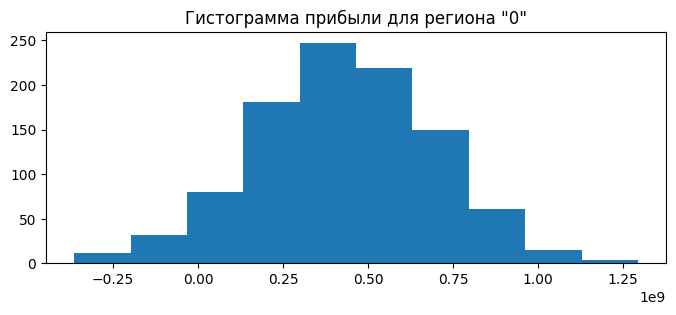

In [27]:
bsp(pred_prod_0, '0')

Для региона "1":

Средняя прибыль: 477948839.2301632
95%-доверительный интервал: (51741836.325 ; 897944131.398)
Вероятность убытка: 0.02


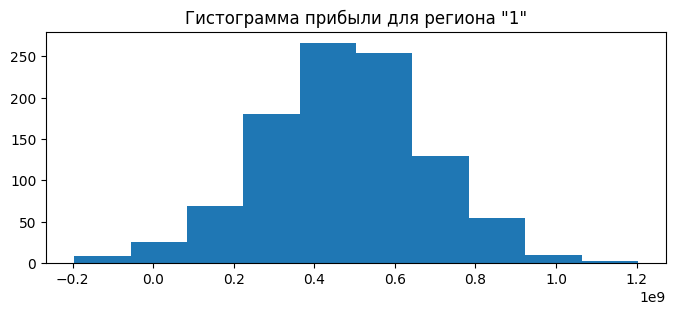

In [28]:
bsp(pred_prod_1, '1')

Для региона "2":

Средняя прибыль: 322147249.3532845
95%-доверительный интервал: (-173464433.945 ; 843529290.071)
Вероятность убытка: 0.123


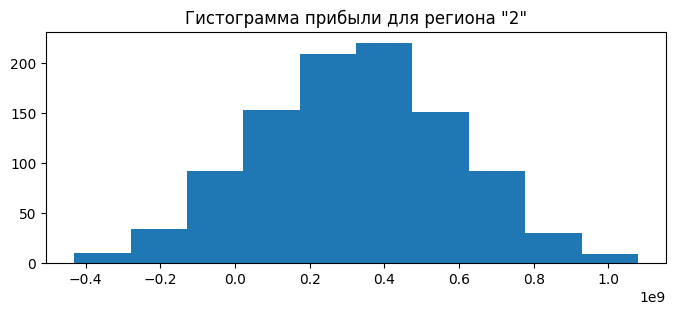

In [29]:
bsp(pred_prod_2, "2")

## Выводы

В процессе исследования были разработаны модели для прогнозирования запасов нефти в трех регионах и сделан прогноз прибыльности разработки. Получены следующие результаты:

- Необходимый для безубыточной разработки скважины средний запас нефти: **111.11 единиц**.

- 
| Параметр              | Регион "0"          | Регион "1"     |Регион "2"  |
| :--------------------: | :---: |:---------------------------:|:----------:|
| Средний запас предсказанного сырья | 92.42 | 68.98 |  95.12   |
|     RMSE модели  | 37.72 | 0.89 |   39.98  |
|Средняя прибыль| 431.54 млн.р. | 477.95 млн.р.  |  322.15 млн.р. |
|95%-доверительный интервал| (-80.92 ; 941.04 ) млн.р.| (51.74 ; 897.94) млн.р.  |  (-173.46 ; 843.53) млн.р. |
|Вероятность убытка| 0.055  |  0.02 | 0.123  |

Таким образом, из соображений минимизации рисков можно рекомендовать к разработке регион "1". Вероятность получения убытков здесь состаляет 1.5%, что существенно ниже, чем в других регионах. Кроме того для этого региона удалось создать гораздо более точную модель предсказания запасов. Благодаря этому, несмотмя на меньший средний запас сырья в скважинах, имеется возможность точнее выбирать места разработки, что увеличивает потенциальную прибыль даже по сравнению с более богатыми нефтью регионами.